# AutoML service

In [236]:
%matplotlib inline
import json
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score
import tsfresh

from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report

import logging

## Build an AutoML Pipeline

## Load Data
The dataset consists of timeseries for 7352 accelerometer readings. Each reading represents an accelerometer reading for 2.56 sec at 50hz (for a total of 128 samples per reading). Each reading corresponds one of six activities (walking, walking upstairs, walking downstairs, sitting, standing and laying). We use only two labels to create a binary classification problem for demonstration purposes.

The dataset is available here: https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

In [237]:
# fetch dataset from uci
download_har_dataset()

In [238]:
# load data
df = load_har_dataset()
y = load_har_classes()

# binary classification
class1, class2 = 2, 3
two_classes = (y==class1) | (y==class2)
df = df[two_classes]
y = y[two_classes]
# change lavel names
y[y==class1] = 0
y[y==class2] = 1
df = df.reset_index(drop=True)
y = y.reset_index(drop=True)

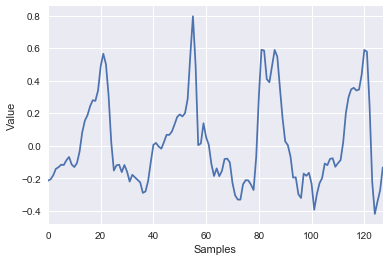

In [239]:
df.loc[0].plot()
plt.xlabel('Samples')
plt.ylabel('Value');

In [240]:
df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-0.215585,-0.207075,-0.182138,-0.142741,-0.132632,-0.117172,-0.119114,-0.089740,-0.069489,-0.115614,...,0.345217,0.436998,0.588969,0.578273,0.246506,-0.222102,-0.420007,-0.344214,-0.274876,-0.134263
1,-0.139810,-0.187628,-0.155011,-0.082122,-0.079723,-0.103602,-0.229672,-0.305656,-0.331781,-0.332108,...,0.546882,0.082013,-0.048092,0.164873,0.178814,-0.081906,-0.323539,-0.233786,-0.104189,-0.194960
2,0.032786,0.016178,-0.073783,-0.213058,-0.381777,-0.428582,-0.407656,-0.307183,-0.118373,-0.062827,...,0.382911,-0.090219,-0.177760,-0.033932,-0.068030,-0.098027,-0.130995,-0.183686,-0.161318,-0.170984
3,-0.157143,-0.137834,-0.184116,-0.103714,-0.101363,-0.084199,-0.088589,-0.206434,-0.224875,-0.245281,...,0.195934,0.393405,0.676694,0.857724,0.596876,0.152647,-0.036636,0.043853,0.120515,-0.027335
4,-0.164657,-0.096840,-0.032734,-0.033651,-0.120096,-0.187973,-0.214090,-0.209802,-0.225381,-0.301140,...,0.259611,0.062731,0.088581,0.095108,-0.114798,-0.278966,-0.292962,-0.191971,-0.083488,-0.156860
5,-0.195952,-0.279866,-0.254661,-0.065027,-0.027639,-0.134345,-0.214562,-0.278056,-0.201539,-0.148378,...,0.235858,0.621956,0.822441,0.374959,-0.217619,-0.230754,-0.041107,-0.072666,-0.146282,-0.191784
6,-0.219461,-0.212965,-0.224088,-0.175570,-0.186145,-0.191256,-0.119096,-0.107610,-0.113380,-0.178694,...,0.290206,0.355233,0.673551,0.919330,0.514680,0.003718,0.065811,0.091919,-0.196235,-0.269685
7,-0.188779,-0.132067,-0.147488,-0.156217,-0.155095,-0.225445,-0.226625,-0.165242,-0.133405,-0.212764,...,0.395386,0.049003,-0.233002,-0.175160,-0.159457,-0.236269,-0.189487,-0.170012,-0.194253,-0.136706
8,-0.241254,-0.263038,-0.176235,-0.117099,-0.117894,-0.171298,-0.240438,-0.215974,-0.212453,-0.217255,...,-0.191879,-0.228009,-0.143863,-0.121514,-0.156120,-0.121337,-0.145056,-0.139969,-0.137880,-0.169037
9,-0.295822,-0.365953,-0.414642,-0.416911,-0.374203,-0.292251,-0.226520,-0.060847,0.252666,0.470014,...,-0.101323,-0.181112,-0.307864,-0.227938,-0.107197,-0.069395,0.025529,0.195286,0.441798,0.707791


## Prep data for feature building
We need to get the data in the format required by TSFRESH:

If there are 100 examples, where each example has 50 samples, we need to go from a (100, 50) dataframe to a (100*50, 2) dataframe as follows:
~~~
measurement|example_id
----------------------
0.5235     |0
0.4284     |0
0.9042     |0
...
0.9042     |100
~~~
See the TSFRESH docs for more details

In [241]:
# values
v = df.stack().values

# ids
ids = []
for i in range(len(y)):
    ids.extend(128*[i])
ids = np.array(ids)

master_df = pd.DataFrame(v, columns=['measurement'])
master_df['example_id'] = ids

## Build Train/Test Set

In [6]:
# build label dataframe
label_df = pd.DataFrame(y.reset_index(drop=True))\
    .reset_index()
label_df.columns = ['example_id', 'label']

# split into training and test 
train_id, test_id = train_test_split(label_df.example_id, random_state=43, test_size=0.2)
train_id = pd.DataFrame(train_id)
test_id  = pd.DataFrame(test_id)

data_train = master_df.merge(train_id, on='example_id')
data_test = master_df.merge(test_id, on='example_id')
print float(data_train.shape[0])/(data_train.shape[0] + data_test.shape[0])

label_train = label_df.merge(train_id, on='example_id')
label_test = label_df.merge(test_id, on='example_id')

0.799902865469


## Build a model

In [8]:
%%time

extraction_settings = MinimalFCParameters()

X_train = extract_features(data_train, column_id='example_id', impute_function=eval('tsfresh.utilities.dataframe_functions.impute'), default_fc_parameters=extraction_settings); 
X_test  = extract_features(data_test, column_id='example_id', impute_function=impute, default_fc_parameters=extraction_settings);

Feature Extraction: 100%|██████████| 412/412 [00:00<00:00, 6334.95it/s]

CPU times: user 546 ms, sys: 112 ms, total: 658 ms
Wall time: 1.16 s


In [9]:
from tpot import TPOTClassifier
from sklearn.metrics import roc_auc_score
tpot = TPOTClassifier(generations=5, population_size=20, max_time_mins=0.2)
tpot.fit(X_train, label_train.label)
roc_auc_score(label_test.label, tpot.predict_proba(X_test)[:,1])

0.94590615501519759

### Compare to Random Forest (baseline)

In [13]:
# from sklearn.ensemble import RandomForestClassifier
# cl = RandomForestClassifier(n_estimators=100, n_jobs=-1)
# cl.fit(X_train, label_train.label)
# roc_auc_score(label_test.label, cl.predict_proba(X_test)[:,1])
import sklearn
scoring = ['roc_auc', 'accuracy']
cv = sklearn.model_selection.cross_validate(cl, X_train, label_train.label, cv=5, scoring=scoring)
mean_accuracy = cv['test_accuracy'].mean()
mean_roc_auc = cv['test_roc_auc'].mean()
mean_accuracy, mean_roc_auc

(0.87487657732338597, 0.94718667279069724)

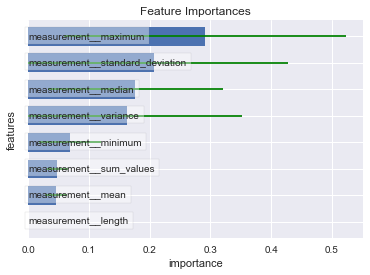

In [30]:
def plot_importances(cl, column_names, n_features=10, ax=None, error_bars = True):
    df_imp = pd.DataFrame({'features': column_names,
                           'importances': cl.feature_importances_})
    errors = np.std([tree.feature_importances_ for tree in cl.estimators_], axis=0)
    df_imp_sub = df_imp.set_index('features').sort_values('importances').tail(n_features)
    if error_bars:
        df_errors = pd.DataFrame({'features': column_names,
                                  'importances': errors})
        df_err_sub = df_errors.set_index('features').loc[df_imp_sub.index]
    else:
        df_err_sub = None
    ax = df_imp_sub.plot(kind='barh', width=.7, legend=False, ax=ax, xerr=df_err_sub, ecolor='g')
    for i,t in enumerate(df_imp_sub.index.tolist()):
        t = ax.text(0.001, i-.06,t)
        t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='grey'))
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.set_title('Feature Importances')
    ax.set_xlim(0.0)
    ax.set_xlabel('importance')
    return df_imp_sub

plot_importances(cl, X_train.columns);

## Export Data
Save training/testing data so we can build and test the AutoML Flask service

In [236]:
import os
output_dir = 'automl_service/data'
data_train.to_json(os.path.join(output_dir, 'data_train.json'))
data_test.to_json(os.path.join(output_dir, 'data_test.json'))
label_train.to_json(os.path.join(output_dir, 'label_train.json'))
label_test.to_json(os.path.join(output_dir, 'label_test.json'))

In [354]:
c = sns.color_palette()

#  Prep

In [ ]:
def get_model_results(evaluated_individuals):
    """For processing model run results, store results as dictionary of AUCS"""
    tpot_results = []
    for i,(k, (steps, auc)) in enumerate(evaluated_individuals.iteritems()):
        model_type = k.split('(')[0]
        tpot_results.append([model_type, i, auc])
    return tpot_results

In [359]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [394]:
label_train = pd.read_json('data/label_train.json')
df = pd.read_json('data/data_train.json')
x_train = df.groupby('example_id').sum()
df.index = df.index.astype(np.int)
label_train = pd.read_json('data/label_train.json')

# Show raw time series data

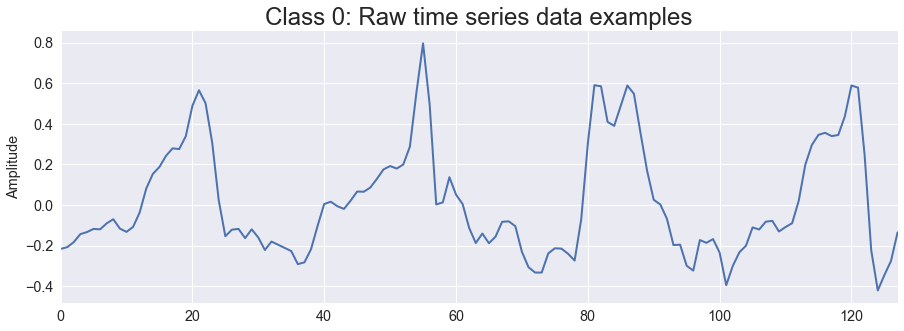

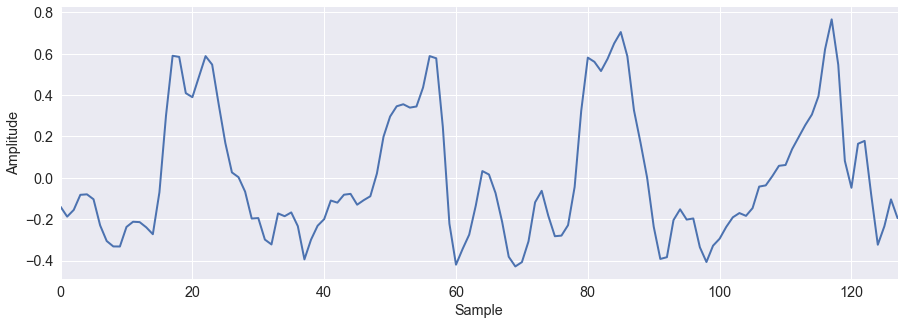

In [396]:
df = pd.read_json('data/data_train.json')
df.index = df.index.astype(int)
for i,(_,_df) in enumerate(df[df.example_id.isin([0, 1])].groupby('example_id')):
    plt.figure()
    _df.index = _df.index%128
    _df.sort_index().measurement.plot(linewidth=2, color=c[0])
    plt.ylabel('Amplitude')
    if i==0:
        plt.title('Class 0: Raw time series data examples', size=24)
plt.xlabel('Sample');

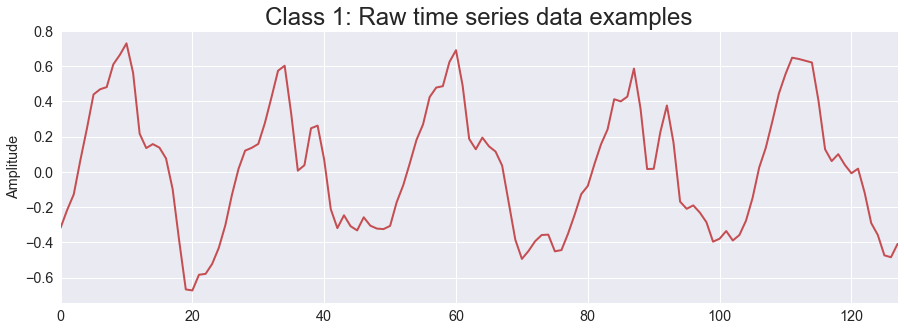

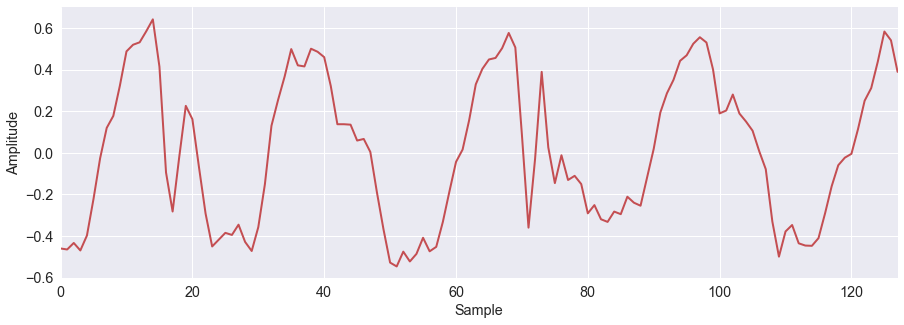

In [397]:
for i,(_,_df) in enumerate(df[df.example_id.isin([1246, 1248])].groupby('example_id')):
    plt.figure()
    _df.index = _df.index%128
    _df.sort_index().measurement.plot(linewidth=2, color=c[2])
    plt.ylabel('Amplitude')
    if i==0:
        plt.title('Class 1: Raw time series data examples', size=24)
plt.xlabel('Sample');

# Use model serve API 

### Train Model

In [418]:
train_url = 'http://0.0.0.0:8080/train_pipeline'
train_files = {'raw_data': open('data/data_train.json', 'rb'),
               'labels'  : open('data/label_train.json', 'rb'),
               'params'  : open('train_parameters_model3.yml', 'rb')}

In [ ]:
r_train = requests.post(train_url, files=train_files)
result_df = json.loads(r_train.json())
automl_experiments = get_model_results(result_df['evaluated_models'])

In [417]:
del result_df['evaluated_models'] 
pprint.pprint(result_df)

{u'featureEngParams': {u'column_id': u'example_id',
                       u'default_fc_parameters': u"['median', 'minimum', 'standard_deviation', 'sum_values', 'variance', 'maximum', 'length', 'mean']",
                       u'impute_function': u'impute'},
 u'mean_cv_accuracy': 0.899190968173843,
 u'mean_cv_roc_auc': 0.9581171933661263,
 u'modelId': 2,
 u'modelType': u"Pipeline(memory=None,\n     steps=[('stackingestimator', StackingEstimator(estimator=LinearSVC(C=25.0, class_weight=None, dual=False, fit_intercept=True,\n     intercept_scaling=1, loss='squared_hinge', max_iter=1000,\n     multi_class='ovr', penalty='l1', random_state=None, tol=1e-05,\n     verbose=0))), ('extratreesclassifier',...imators=100, n_jobs=1,\n           oob_score=False, random_state=None, verbose=0, warm_start=False))])",
 u'trainShape': [1647, 8],
 u'trainTime': 15.418572902679443}


(0.8, 0.91434885327438531)

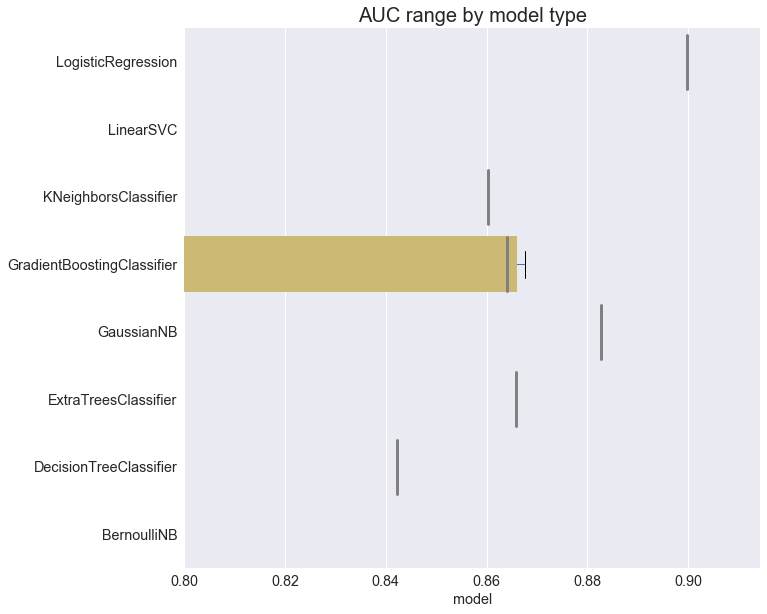

In [413]:
automl_experiments = pd.DataFrame(automl_experiments, columns=['model', 'id', 'auc']).sort_values('model')
sns.set_style(style='darkgrid')
f, ax = plt.subplots(figsize=(10,10))
box = automl_experiments.boxplot(column='auc', by='model', rot=0, vert=False,
                             ax=ax, patch_artist=True, return_type='dict',
                             widths=0.8)
ax.grid(axis='y')
ax.set_title('AUC range by model type', size=20)
plt.suptitle('')

for b in box['auc']['boxes']:
    color = sns.color_palette()[4] 
    b.set(color=color, linewidth=2)
    b.set(facecolor=color, linewidth=2)

# for median in bp['medians']:
for median in box['auc']['medians']:
    median.set(color='grey', linewidth=3)

plt.xlim(0.8)

### Serve model prediction

In [211]:
train_url = 'http://0.0.0.0:8080/serve_prediction'
test_files = {'raw_data': open('data/data_test.json', 'rb'),
              'params' : open('test_parameters.yml', 'rb')}

In [212]:
r_test  = requests.post(serve_url, files=test_files)
result = pd.read_json(r_test.json()).set_index('id')

In [214]:
result.index = result.index.astype(np.int)
result = result.loc[label_test.example_id]
roc_auc_score(label_test.label, result.score)

0.9374168882978724

In [192]:
label_test = pd.read_json('data/label_test.json')
label_test

,example_id,label
0,8,1
1,15,1
10,61,0
100,559,1
101,560,0
102,565,0
103,576,0
104,580,1
105,588,1
106,593,1


In [54]:
import os
import requests
base_url = "http://0.0.0.0:8080"
train_url = os.path.join(base_url, 'train_pipeline')
serve_url = os.path.join(base_url, 'serve_prediction')

train_files = {'raw_data': open('data/data_train.json', 'rb'),
               'labels' : open('data/label_train.json', 'rb'),
               'params' : open('train_parameters.yml', 'rb')}

train_files = {'raw_data': open('data/data_train.json', 'rb'),
               'labels' : open('data/label_train.json', 'rb'),
               'params' : open('train_parameters_model2.yml', 'rb')}


test_files = {'raw_data': open('data/data_test.json', 'rb'),
              'params' : open('test_parameters.yml', 'rb')}
r_train = requests.post(train_url, files=train_files)
r_test  = requests.post(serve_url, files=test_files)


# load data and match up with labels
result = pd.read_json(r_test.json())
result.index = result.index.astype(np.int)
# result = result.loc[label_test.example_id]

In [21]:
import os
import pprint
import requests

base_url = "http://0.0.0.0:8080"

url = os.path.join(base_url, 'train_pipeline')
train_files = {'raw_data': open('data/data_train.json', 'rb'),
               'labels' : open('data/label_train.json', 'rb'),
               'params' : open('train_parameters_model2.yml', 'rb')}
r  = requests.post(url,
        files=train_files)
import json
res = json.loads(r.json())
for k in res:
    print k, res[k]
    
serve_url = os.path.join(base_url, 'serve_prediction')
test_files = {'raw_data': open('data/data_test.json', 'rb'),
              'params' : open('test_parameters_model2.yml', 'rb')}
r  = requests.post(serve_url, files=test_files)

# parse result
result = pd.read_json(r.json())
result.index = result.index.astype(np.int)
label_test = pd.read_json('data/label_test.json')
result = result.loc[label_test.example_id]
res = json.loads(r.json())
for k in res:
    print k, res[k]

trainTime 13.6129848957
modelType Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power=6, n_components=None, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=False)), ('randomforestclassifier', RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features='auto',
      ...mators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])
trainShape [1647, 8]
mean_cv_accuracy 0.879726859371
mean_cv_roc_auc 0.95001833214
modelId 2
score {u'1524': 0.009510063, u'1949': 0.3352066078, u'342': 0.2801494661, u'810': 0.0561095703, u'348': 0.666370728, u'815': 0.0635138554, u'715': 0.1803371411, u'1251': 0.522133949, u'713': 0.1606510528, u'710': 0.1414875105, u'1492': 0.261832681, u'1493': 0.2087980222, u'1495': 0.4827712225, u'1499': 0.082636695, u'423': 0.9825, u'1068': 0.940049176, u'1704': 0.9746402739, u'1708': 0.6833010023, u'424': 0.9877070707, u'298': 0.40075472

In [30]:
base_url = "http://0.0.0.0:8080"

url = os.path.join(base_url, 'train_pipeline')
train_files = {'raw_data': open('data/data_train.json', 'rb'),
               'labels' : open('data/label_train.json', 'rb'),
               'params' : open('train_parameters.yml', 'rb')}
r  = requests.post(url,
        files=train_files)

base_url = "http://0.0.0.0:8080"

url = os.path.join(base_url, 'models')
r  = requests.get(url)
r.json()
r = json.loads(r.json())
for k in r:
    print k, r[k]

 1 {u'trainTime': 1.980497121810913, u'modelType': u"RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n            max_depth=None, max_features='auto', max_leaf_nodes=None,\n            min_impurity_decrease=0.0, min_impurity_split=None,\n            min_samples_leaf=1, min_samples_split=2,\n            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,\n            oob_score=False, random_state=None, verbose=0,\n            warm_start=False)", u'trainShape': [1647, 8], u'mean_cv_accuracy': 0.8797546036388797, u'mean_cv_roc_auc': 0.9293335716725007, u'modelId': 1}
2 {u'trainTime': 13.612984895706177, u'modelType': u"Pipeline(memory=None,\n     steps=[('pca', PCA(copy=True, iterated_power=6, n_components=None, random_state=None,\n  svd_solver='randomized', tol=0.0, whiten=False)), ('randomforestclassifier', RandomForestClassifier(bootstrap=False, class_weight=None,\n            criterion='entropy', max_depth=None, max_features='auto',\n      ...mators=10

In [8]:
import cPickle
data_train = pd.read_json('data/data_train.json')
label_train = pd.read_json('data/label_train.json')
data_test = pd.read_json('data/data_test.json')
label_test = pd.read_json('data/label_test.json')

X_train  = extract_features(data_train, column_id='example_id', impute_function=impute, default_fc_parameters=extraction_settings); 
X_test  = extract_features(data_test, column_id='example_id', impute_function=impute, default_fc_parameters=extraction_settings);

In [121]:
# y.loc[X_train.index]
y = label_train.set_index('example_id')
y.loc[X_train.index]

,label
id,
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
9,1


In [91]:
tpot = TPOTClassifier(verbosity=2, max_time_mins=0.4)
tpot.fit(X_train, label_train.label)

TPOTClassifier(config_dict={'sklearn.ensemble.GradientBoostingClassifier': {'max_features': array([ 0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,  0.45,
        0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,
        0.95,  1.  ]), 'learning_rate': [0.001, 0.01, 0.1, 0.5, 1.0], 'min_samples_... 0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,
        0.95,  1.  ])}, 'sklearn.preprocessing.RobustScaler': {}},
        crossover_rate=0.1, cv=5, disable_update_check=False,
        generations=1000000, max_eval_time_mins=5, max_time_mins=0.4,
        mutation_rate=0.9, n_jobs=1, offspring_size=100,
        population_size=100, random_state=None, scoring=None,
        subsample=1.0, verbosity=0, warm_start=False)

In [93]:
roc_auc_score(label_test.label, tpot.fitted_pipeline_.predict_proba(X_test)[:,1])

0.52242828647416417

In [164]:
result.index.dtype

dtype('O')

In [181]:
r_test.json()

{u'score': {u'1003': 0.9968984237,
  u'1005': 0.9983929293,
  u'1006': 0.0510467634,
  u'1015': 0.9084673218,
  u'1049': 0.1394819306,
  u'1056': 0.9902811462,
  u'106': 0.9427784253,
  u'1068': 0.9999963683,
  u'1070': 0.9999913881,
  u'1073': 0.9999999921,
  u'1079': 0.0121356654,
  u'1081': 0.0060362017,
  u'1082': 0.0736329632,
  u'1086': 0.0192956131,
  u'1093': 0.9973755892,
  u'1095': 0.9999994213,
  u'1098': 0.0689822524,
  u'1108': 0.9979197548,
  u'111': 0.8531302433,
  u'1115': 0.1434052464,
  u'1118': 0.0377048213,
  u'112': 0.8381322637,
  u'1129': 0.9996190599,
  u'1131': 0.9880000176,
  u'1137': 0.0468560097,
  u'114': 0.9644218543,
  u'1142': 0.9998357534,
  u'1143': 0.9993005966,
  u'1162': 0.0218119335,
  u'1163': 0.0076520218,
  u'1168': 0.0241575508,
  u'1183': 0.0243817279,
  u'1188': 0.9956774048,
  u'1189': 0.9970821574,
  u'1199': 0.9995269733,
  u'1202': 0.9999928328,
  u'1206': 0.0822399114,
  u'1207': 0.0252468387,
  u'1210': 0.0340375878,
  u'1212': 0.081115

In [168]:
# load data and match up with labels
result = pd.DataFrame(json.loads(r_test.content))
result.index = result.index.astype(np.int)
result = result.loc[label_test.example_id]
roc_auc_score(label_test.label, result.values)

0.94723594224924013

In [38]:
test_url = os.path.join(base_url, 'testing')
r_testing  = requests.post(test_url, files=test_files)
r_testing

<Response [500]>

In [48]:
import json
json.dumps({'scores': [1,2]})
s=pd.Series([1,2], name='scores')
s.to_json(orient='values')

'[1,2]'

# Pickle Model

In [95]:
data_train = pd.read_json('data/data_train.json')
label_train = pd.read_json('data/label_train.json')
data_test = pd.read_json('data/data_test.json')
label_test = pd.read_json('data/label_test.json')

data_train['time'] = data_train.index%128
data_train

,example_id,measurement,time
0,0,-0.215584,0
1,0,-0.207075,1
10,0,-0.131722,10
100,0,-0.233793,100
1000,7,-0.047772,104
10000,95,-0.549654,16
100000,951,-0.288609,32
100001,951,-0.370606,33
100002,951,-0.383269,34
100003,951,-0.315036,35


# Analyze model results

In [278]:
# models tried and model results
tpot.evaluated_individuals_

# number of models
len(tpot.evaluated_individuals_)

226

## See how different models performed

In [269]:
def get_model_results(evaluated_individuals):
    """For processing model run results, store results as dictionary of AUCS"""
    tpot_results = []
    for i,(k, (steps, auc)) in enumerate(evaluated_individuals.iteritems()):
        model_type = k.split('(')[0]
        tpot_results.append([model_type, i, auc])
    return tpot_results
automl_results = get_model_results(tpot.evaluated_individuals_)
automl_results = pd.DataFrame(automl_results, columns=['model', 'id', 'auc']).sort_values('model')

In [277]:
automl_results.groupby('model').count()

,id,auc
model,,
BernoulliNB,9,9
DecisionTreeClassifier,5,5
ExtraTreesClassifier,109,109
GaussianNB,13,13
GradientBoostingClassifier,1,1
KNeighborsClassifier,23,23
LinearSVC,15,15
LogisticRegression,25,25
MultinomialNB,5,5


## Build BoxPlot

(0.8, 0.90000000000000002)

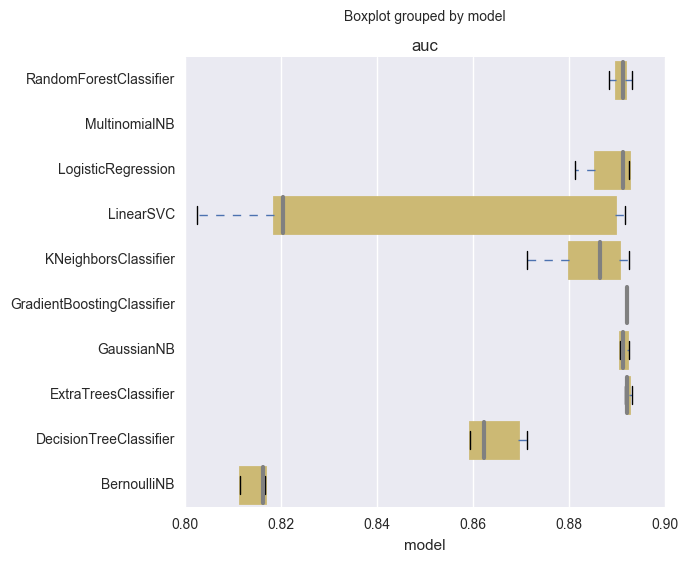

In [279]:
import seaborn
sns.set_style(style='darkgrid')
f, ax = plt.subplots(figsize=(6,6))
box = automl_results.boxplot(column='auc', by='model', rot=0, vert=False,
                             ax=ax, patch_artist=True, return_type='dict',
                             widths=0.8)
ax.grid(axis='y')

for b in box['auc']['boxes']:
    color = sns.color_palette()[4] 
    b.set(color=color, linewidth=2)
    b.set(facecolor=color, linewidth=2)

# for median in bp['medians']:
for median in box['auc']['medians']:
    median.set(color='grey', linewidth=3)

plt.xlim(0.8)

TypeError: 'AxesSubplot' object has no attribute '__getitem__'

In [150]:
pd.DataFrame(model_types)

ValueError: arrays must all be same length

In [1]:
from tpot import TPOTClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

digits = load_digits()
n_trees = [10,25,50,75,100,200,300,400,500,600,700,800,900,1000]
scores = []
for n in n_trees:
    cl = RandomForestClassifier(n_estimators=n)
    score = cross_val_score(cl, digits.data, digits.target, cv=10)
    scores.append(score)

NameError: name 'RandomForestClassifier' is not defined

(0, 500)

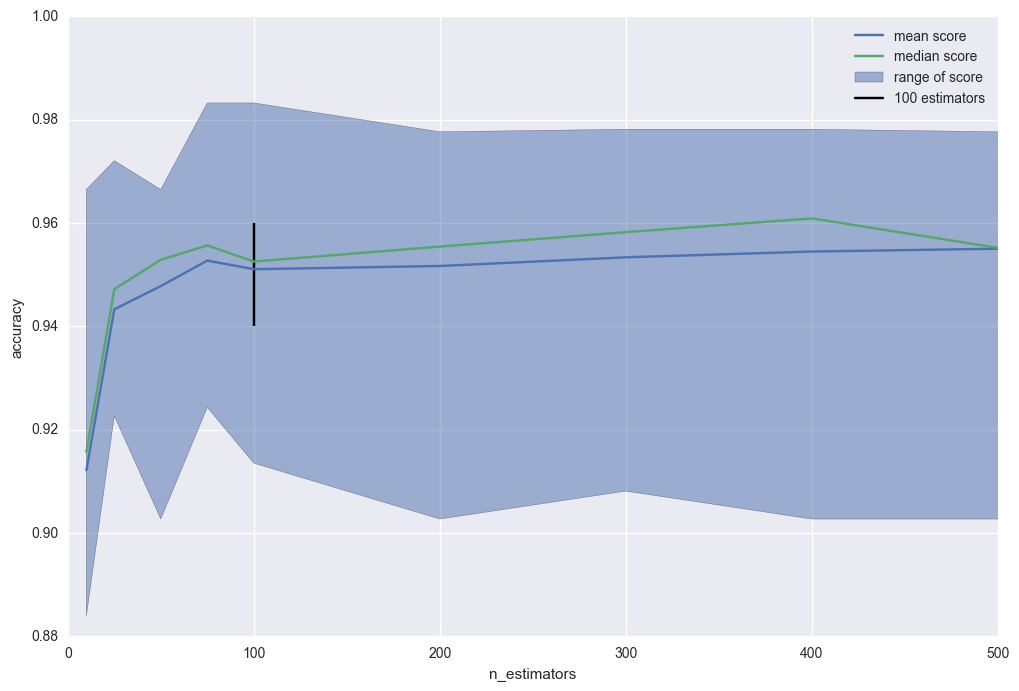

In [97]:
plt.figure(figsize=(12,8))
scores = np.array(scores)
scores_mean = scores.mean(axis=1)
scores_median = np.median(scores2, axis=1)
scores_min = scores.min(axis=1)
scores_max = scores.max(axis=1)
plt.plot(n_trees, scores_mean, label='mean score')
plt.fill_between(n_trees, scores_min, scores_max, alpha=0.5, label='range of score')
plt.plot(n_trees, scores_median, label='median score')
plt.vlines(100, 0.94, 0.96, label='100 estimators')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.legend()
plt.xlim(0,500)

In [72]:
scores.shape

(14, 10)

In [57]:
np.hstack([X_train]*5).shape

(1347, 320)

In [69]:
X_train2 = np.hstack([X_train]*5)
n_trees = [10,25,50,75,100,200,300,400,500,600,700,800,900,1000]
scores2 = []
for n in n_trees:
    cl = RandomForestClassifier(n_estimators=n)
    cl.fit(X_train2, y_train)
    score = cross_val_score(cl, digits.data, digits.target, cv=10)
    scores2.append(score)

In [63]:
np.median(scores2, axis=1)

array([ 0.91655089,  0.94709479,  0.94680183,  0.95544693,  0.94987585,
        0.96078401,  0.96110991,  0.95541589,  0.95820919,  0.95533708,
        0.95567833,  0.9554752 ,  0.95543141,  0.95263811])

(0, 500)

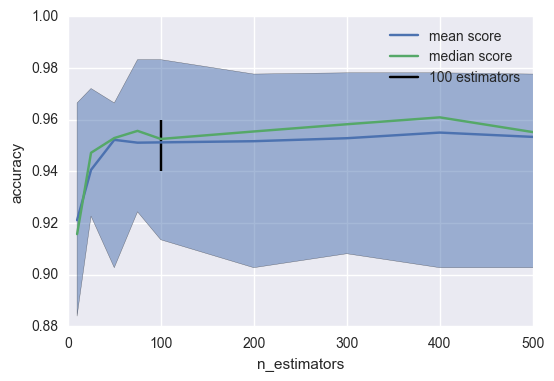

In [95]:
scores2 = np.array(scores2)
scores_mean = scores2.mean(axis=1)
scores_median = np.median(scores2, axis=1)
scores_std = scores2.std(axis=1)
plt.plot(n_trees, scores_mean, label='mean score')
plt.fill_between(n_trees, scores_min, scores_max, alpha=0.5)
plt.plot(n_trees, scores_median, label='median score')
plt.vlines(100, 0.94, 0.96, label='100 estimators')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.legend()
plt.xlim(0,500)

In [102]:
import re
from IPython.core.magic import Magics, magics_class, cell_magic, line_magic, needs_local_scope
from IPython.display import display_javascript
try:
    from traitlets.config.configurable import Configurable
    from traitlets import Bool, Int, Unicode
except ImportError:
    from IPython.config.configurable import Configurable
    from IPython.utils.traitlets import Bool, Int, Unicode
try:
    from pandas.core.frame import DataFrame, Series
except ImportError:
    DataFrame = None
    Series = None


@magics_class
class SqlMagic(Magics, Configurable):
    pass

In [107]:
import traitlets
import iPython
iPython.__version__

ImportError: No module named iPython